In [145]:
import pandas as pd
import numpy as np
df = pd.read_csv('Sunspots.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.drop(index=df[df["Monthly Mean Total Sunspot Number"] == 0].index, inplace=True)

df.columns = [ "Date", "Sunspot"]


df["Date"] = pd.to_datetime(df["Date"])


df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month


df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)


In [146]:

#df["Sunspot_lag1"] = df["Sunspot"].shift(1)


df["Sunspot_lag12"] = df["Sunspot"].shift(12)


In [147]:

df["MA_3"] = df["Sunspot"].rolling(window=3).mean()


df["MA_12"] = df["Sunspot"].rolling(window=12).mean()


In [148]:

df["Diff_11Year"] = df["Sunspot"] - df["Sunspot"].shift(132)


In [149]:

df = df.dropna().reset_index(drop=True)


In [150]:

features = [
     "Sunspot_lag12", 
    "MA_3", "MA_12", 
    "Diff_11Year", 
    "Month_sin", "Month_cos", 
    "Year", "Month"
]


target = "Sunspot"


X = df[features]
y = df[target]


In [151]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score


model = LGBMRegressor()
model.fit(X_train, y_train)


y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 8
[LightGBM] [Info] Start training from score 79.487372


In [152]:

n = len(df)


train_end = int(n * 0.7)
val_end = int(n * 0.9)


X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]


X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]


X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]


date_train = df.iloc[:train_end]["Date"]
date_val = df.iloc[train_end:val_end]["Date"]
date_test = df.iloc[val_end:]["Date"]


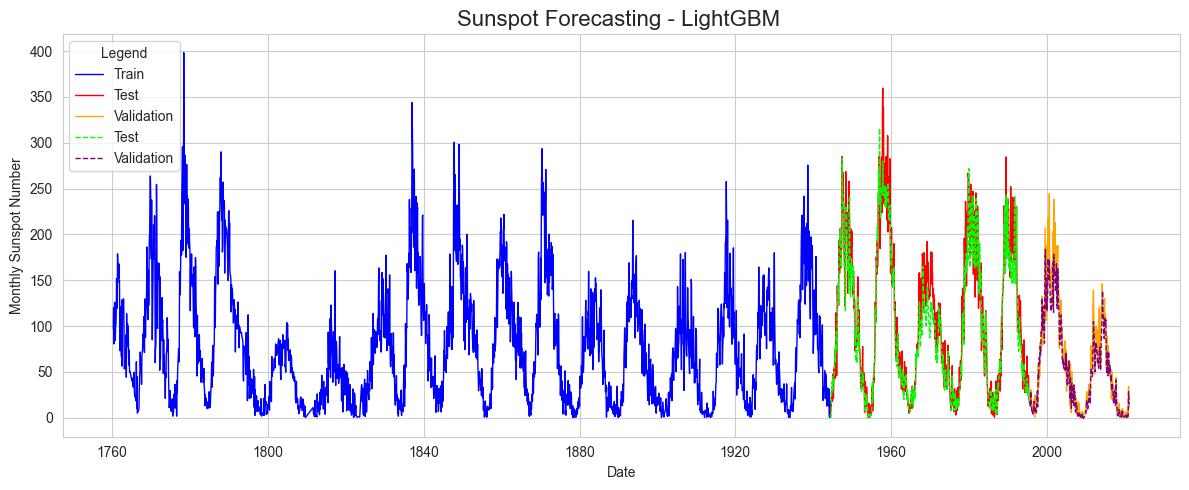

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))


plot_df = pd.DataFrame({
    "Date": pd.concat([date_train, date_val, date_test]),
    "Actual": pd.concat([y_train, y_val, y_test]),
    "Type": (["Train"] * len(y_train)) + (["Test"] * len(y_val)) + (["Validation"] * len(y_test))
})


pred_df = pd.DataFrame({
    "Date": pd.concat([date_val, date_test]),
    "Predicted": pd.concat([pd.Series(y_pred_val, index=date_val.index),
                            pd.Series(y_pred_test, index=date_test.index)]),
    "Type": (["Test"] * len(y_pred_val)) + (["Validation"] * len(y_pred_test))
})


sns.lineplot(data=plot_df, x="Date", y="Actual", hue="Type", palette={"Train": "blue", "Validation": "orange", "Test": "red"}, linewidth=1)


sns.lineplot(data=pred_df, x="Date", y="Predicted", hue="Type", palette={"Validation": "purple", "Test": "lime"}, linestyle="--", linewidth=1)

# Grafik başlık ve düzenlemeler
plt.title("Sunspot Forecasting - LightGBM ", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Monthly Sunspot Number")
plt.legend(title="Legend", loc="upper left")
plt.tight_layout()
plt.show()


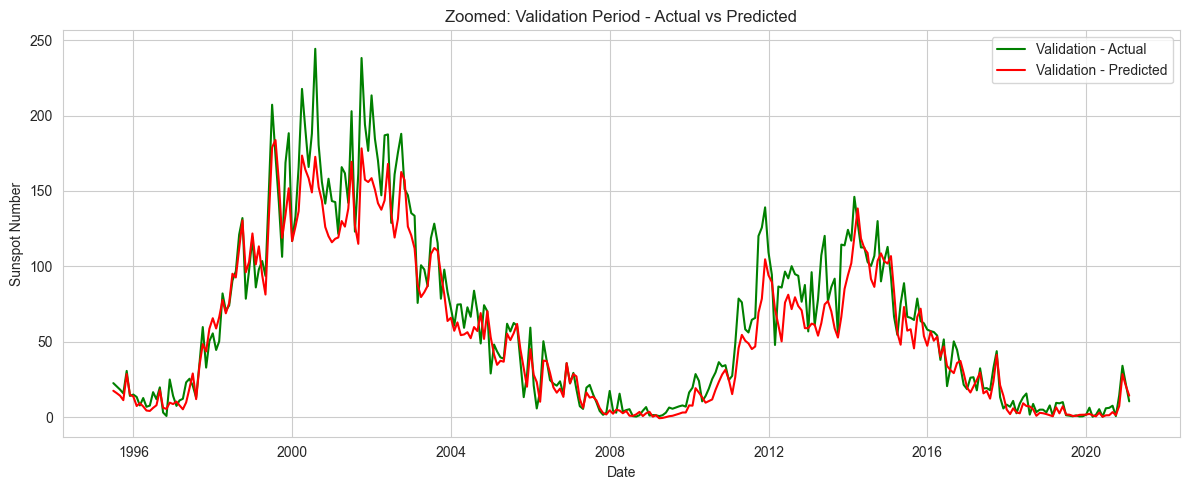

In [154]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=date_test, y=y_test, label="Validation - Actual", color="green")
sns.lineplot(x=date_test, y=y_pred_test, label="Validation - Predicted", color="red", linestyle="-")

plt.title("Zoomed: Validation Period - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [155]:
# Train ve Validation setlerini birleştir
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])


In [156]:
from lightgbm import LGBMRegressor

# Modeli tanımla
model = LGBMRegressor(random_state=42)

# Sadece geçmiş verilerle eğit (train + val)
model.fit(X_trainval, y_trainval)

# Test setini tahmin et (gelecek!)
y_pred_test = model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number of data points in the train set: 2759, number of used features: 8
[LightGBM] [Info] Start training from score 86.436173


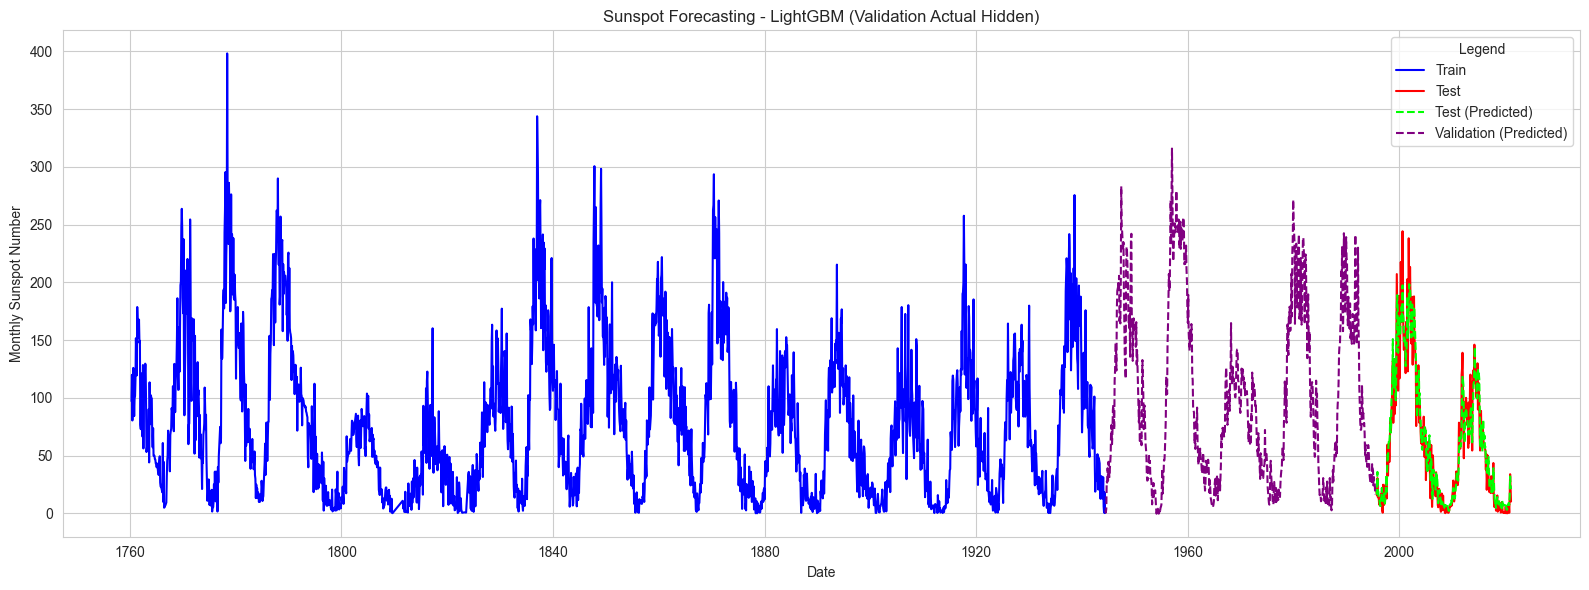

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

# Train seti (gerçek değerler)
sns.lineplot(x=date_train, y=y_train, label="Train", color="blue")

# Test seti (gerçek ve tahmin)
sns.lineplot(x=date_test, y=y_test, label="Test", color="red")
sns.lineplot(x=date_test, y=y_pred_test, label="Test (Predicted)", color="lime", linestyle='--')

# Validation seti (tahmin)
sns.lineplot(x=date_val, y=y_pred_val, label="Validation (Predicted)", color="purple", linestyle='--')

plt.title("Sunspot Forecasting - LightGBM (Validation Actual Hidden)")
plt.xlabel("Date")
plt.ylabel("Monthly Sunspot Number")
plt.legend(title="Legend")
plt.grid(True)
plt.tight_layout()
plt.show()


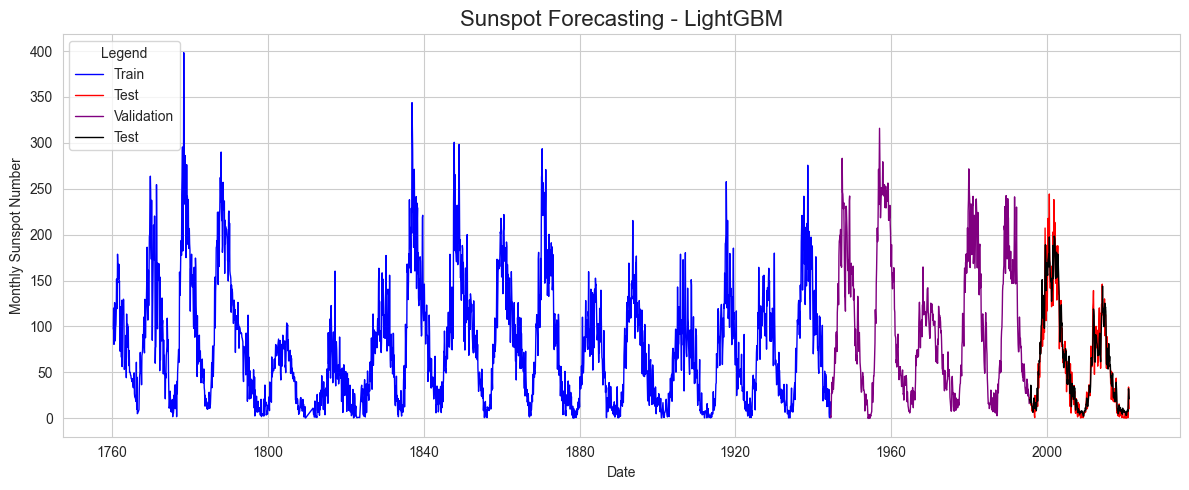

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))


plot_df = pd.DataFrame({
    "Date": pd.concat([date_train, date_test]),  
    "Actual": pd.concat([y_train, y_test]),
    "Type": (["Train"] * len(y_train)) + (["Test"] * len(y_test))
})


pred_df = pd.DataFrame({
    "Date": pd.concat([date_val, date_test]),
    "Predicted": pd.concat([
        pd.Series(y_pred_val, index=date_val.index),
        pd.Series(y_pred_test, index=date_test.index)
    ]),
    "Type": (["Validation"] * len(y_pred_val)) + (["Test"] * len(y_pred_test))
})


sns.lineplot(
    data=plot_df, x="Date", y="Actual", hue="Type",
    palette={"Train": "blue", "Test": "red"}, linewidth=1
)


sns.lineplot(
    data=pred_df, x="Date", y="Predicted", hue="Type",
    palette={"Validation": "purple", "Test": "black"},
    linestyle="-", linewidth=1
)

plt.title("Sunspot Forecasting - LightGBM", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Monthly Sunspot Number")
plt.legend(title="Legend", loc="upper left")
plt.tight_layout()
plt.show()


RMSE: 26.254


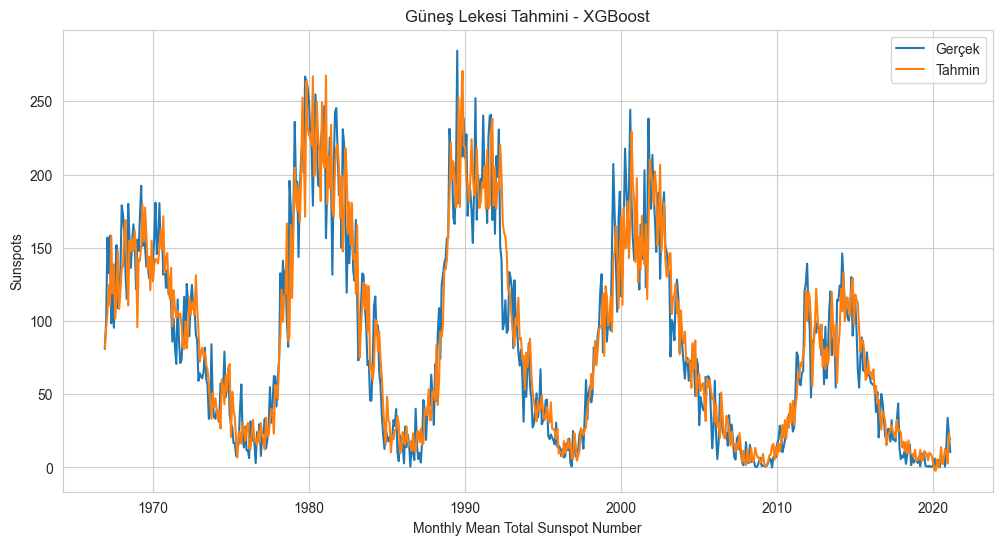

In [159]:
import pandas as pd
import numpy as np
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Veri Yükleme
df = pd.read_csv('Sunspots.csv')

# Tarih kolonunu datetime yapalım (örnek: 'Date' veya 'Year')
df['Date'] = pd.to_datetime(df['Date'])  # Dosyana göre bu değişebilir

# 2. Lag feature oluşturma (önceki aylara / yıllara ait güneş lekesi verileri)
def create_lags(data, lags):
    for lag in range(1, lags+1):
        data[f'sunspot_lag_{lag}'] = data['Monthly Mean Total Sunspot Number'].shift(lag)
    return data

df = create_lags(df, 12)  # Son 12 aya/yıla kadar gecikmeler

# Eksik değerleri düşürelim
df.dropna(inplace=True)

# 3. Eğitim ve Test verisi oluşturma
train_size = int(len(df)*0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# 4. Modelde kullanılacak X ve y
feature_cols = [col for col in df.columns if 'lag' in col]
X_train, y_train = train[feature_cols], train['Monthly Mean Total Sunspot Number']
X_test, y_test = test[feature_cols], test['Monthly Mean Total Sunspot Number']

# 5. Modeli eğit
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

# 6. Tahmin yap
y_pred = model.predict(X_test)

# 7. Performans değerlendirme
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.3f}')

# 8. Grafik çizimi
plt.figure(figsize=(12,6))
plt.plot(df['Date'].iloc[train_size:], y_test, label='Gerçek')
plt.plot(df['Date'].iloc[train_size:], y_pred, label='Tahmin')
plt.title('Güneş Lekesi Tahmini - XGBoost')
plt.xlabel('Monthly Mean Total Sunspot Number')
plt.ylabel('Sunspots')
plt.legend()
plt.show()


Validation RMSE: 29.952
Test RMSE: 25.550


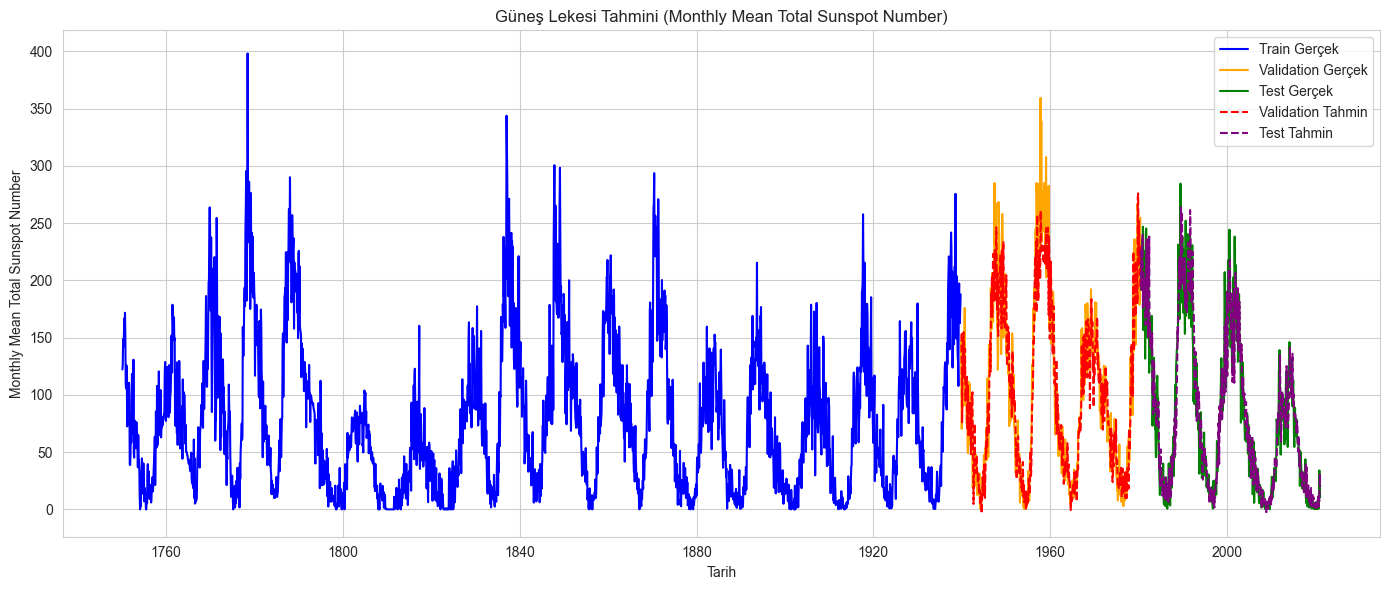

In [160]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Veri Yükleme
df = pd.read_csv('Sunspots.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 2. Yeni isimlendirmeye uygun hale getir: 'Monthly Mean Total Sunspot Number'
target_col = 'Monthly Mean Total Sunspot Number'

# 3. Lag feature oluşturma
def create_lags(data, lags, target):
    for lag in range(1, lags+1):
        data[f'lag_{lag}'] = data[target].shift(lag)
    return data

df = create_lags(df, 12, target_col)
df.dropna(inplace=True)

# 4. Train, Validation, Test bölme
total_len = len(df)
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# 5. Feature ve target setleri
feature_cols = [col for col in df.columns if 'lag_' in col]

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]
X_test, y_test = test[feature_cols], test[target_col]

# 6. Model eğitimi
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

# 7. Tahminler
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# 8. Performans
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Validation RMSE: {rmse_val:.3f}')
print(f'Test RMSE: {rmse_test:.3f}')

# 9. Grafik
plt.figure(figsize=(14,6))

# Gerçek değerler
plt.plot(train['Date'], y_train, label='Train Gerçek', color='blue')
plt.plot(val['Date'], y_val, label='Validation Gerçek', color='orange')
plt.plot(test['Date'], y_test, label='Test Gerçek', color='green')

# Tahmin değerleri
plt.plot(val['Date'], y_val_pred, 'r--', label='Validation Tahmin')
plt.plot(test['Date'], y_test_pred, 'purple', linestyle='--', label='Test Tahmin')

plt.title('Güneş Lekesi Tahmini (Monthly Mean Total Sunspot Number)')
plt.xlabel('Tarih')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
